# Zaawansowane przetwarzanie obrazów

## Klasyfikacja - rozszerzenie

In [1]:
# Install the requirements
!pip install lightning albumentations timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Biblioteka `albumentations`

[albumentations](https://albumentations.ai/) jest zaawansowaną biblioteką umożliwiającą augmentację danych w różnych zadaniach (klasyfikacja, regresja, segmentacja detekcja). Wykorzystamy ją do wzbogacania danych ze zbioru zdjęć psów i kotów.

### Zadanie

Zapoznaj się z tutorialem `albumentations` i zdefiniuj klasę dziedziczącą po `torch.utils.data.Dataset`, która będzie odpowiadała za wczytywanie, augmentowanie i zwracanie obrazów wraz z odpowiadającymi im etykietami: https://albumentations.ai/docs/examples/pytorch_classification/#Define-a-PyTorch-dataset-class.

Na podstawie dokumentacji [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) zaimplementuj własny moduł porządkujący kod obsługi danych. Podobnie jak w tutorialu, to w nim umieść augmentacje treningowe oraz transformacje dla zbioru walidacyjnego i testowego używając obiektów biblioteki `albumentations` (zamiast `torchvision`).

Do podziału ścieżek na zbiór treningowy, walidacyjny i testowy można wykorzystać funkcję biblioteki `scikit-learn`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Wytrenuj model z poprzednich zajęć zastępując osobno przekazywane obiekty `DataLoader` zaimplementowanym `LightningDataModule`.

In [2]:
import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import shutil
from urllib.request import urlopen
from pathlib import Path
import lightning.pytorch as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 32

In [5]:
from torch.utils.data import Dataset


class CatsVsDogsDataset(Dataset):
  def __init__(self, image_paths, transforms=None):
    self.image_paths = image_paths
    self.transforms = transforms

  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self, idx):
    image_filepath = self.image_paths[idx]
    image = cv2.imread(str(image_filepath))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat": #["dataset", "train", "cat", "image1.jpg"] wybieramy kota
      label = 1
    else:
      label = 0

    if self.transforms is not None:
      image = self.transforms(image=image)["image"] #.to(device)

    return image, label

In [6]:
import os
import shutil
from urllib.request import urlopen
from pathlib import Path

import lightning.pytorch as pl
from torch.utils.data import DataLoader

import albumentations as A


class CatsVsDogsDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
            A.SmallestMaxSize(max_size=160), # Przeskaluj obraz tak, aby jego dłuższy bok miał max 160 px (z zachowaniem proporcji)
            A.ShiftScaleRotate(              # Losowo przesuń, skaluj i obróć obraz
              shift_limit=0.05,              # Przesunięcie do 5% rozmiaru w pionie/poziomie
              scale_limit=0.05,              # Skalowanie w zakresie ±5%
              rotate_limit=15,               # Rotacja w zakresie ±15 stopni
              p=0.5                          # Prawdopodobieństwo zastosowania transformacji
            ),
            A.RandomCrop(height=128, width=128), # Wytnij losowy fragment 128x128 px
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5), # Losowo przesunięcia kolorów RGB
            A.RandomBrightnessContrast(p=0.5), # Jasność/kontrast losowo zmienione z 50% szansą
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalizacja
            ToTensorV2(),
        ])

        self.transforms = A.Compose([
            A.SmallestMaxSize(max_size=160),
            A.CenterCrop(height=128, width=128),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None


    def prepare_data(self):
        # Download and unpack the data if necessary
        if not os.path.exists('PetImages'):
            response = urlopen('https://chmura.put.poznan.pl/s/VtRYnXtQPpEtlqz/download')
            with open('images.zip', 'wb') as output_file:
                shutil.copyfileobj(response, output_file)

            shutil.unpack_archive('images.zip')

            images_paths = Path('PetImages').rglob('*.jpg')
            for image_path in images_paths:
                if cv2.imread(str(image_path)) is None:
                    image_path.unlink()


    def setup(self, stage=None):
        # Split the data and assign datasets for use in dataloaders
        images_paths = sorted(Path('PetImages').rglob('*.jpg'))


        train_paths, test_paths = train_test_split(images_paths, test_size=0.3, random_state=42)
        test_paths, val_paths = train_test_split(test_paths, test_size=0.5, random_state=42)

        self.train_dataset = CatsVsDogsDataset(train_paths, self.augmentations)
        self.val_dataset = CatsVsDogsDataset(val_paths, self.transforms)
        self.test_dataset = CatsVsDogsDataset(test_paths, self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE)

In [7]:
import lightning.pytorch as pl
import torchmetrics
import torch
import torchvision

from torch import nn
class CatsVsDogsModel(pl.LightningModule):
  def __init__(self, num_classes: int):
    super().__init__()
    self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    self.network = nn.Sequential(
        self.model,
        nn.Linear(in_features=1000, out_features=512),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=256, out_features=num_classes)
    )

    self.loss_function = nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

    self.save_hyperparameters()

  def forward(self, x):
    return self.network(x)

  def training_step(self, batch, batch_idx):

      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('train_loss', loss, prog_bar=True)
      self.log('train_acc', self.accuracy.compute(), prog_bar=True)

      return loss

  def test_step(self, batch, batch_idx):
      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('test_loss', loss)
      self.log('test_acc', self.accuracy.compute())

  def validation_step(self, batch, batch_idx):

      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('val_loss', loss, prog_bar=True)
      self.log('val_acc', self.accuracy.compute(), prog_bar=True)

  def configure_optimizers(self):
     return torch.optim.Adam(self.parameters(), lr=LR)


In [8]:
model = CatsVsDogsModel(num_classes=2)
Data_modula = CatsVsDogsDataModule()

checkpoint_callback_torchvision = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', verbose=True, dirpath='checkpoints/model_torchvision')

#Monitoruje val_acc i zapisuje najlpszy model do pliku
trainer = pl.Trainer(accelerator='gpu', callbacks=[checkpoint_callback_torchvision], max_epochs=EPOCHS)
trainer.fit(model, Data_modula)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s] 
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
--------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 546: 'val_acc' reached 0.90479 (best 0.90479), saving model to '/content/checkpoints/model_torchvision/epoch=0-step=546.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 546: 'val_acc' reached 0.90479 (best 0.90479), saving model to '/content/checkpoints/model_torchvision/epoch=0-step=546.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 1092: 'val_acc' reached 0.91961 (best 0.91961), saving model to '/content/checkpoints/model_torchvision/epoch=1-step=1092.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1092: 'val_acc' reached 0.91961 (best 0.91961), saving model to '/content/checkpoints/model_torchvision/epoch=1-step=1092.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1638: 'val_acc' reached 0.92474 (best 0.92474), saving model to '/content/checkpoints/model_torchvision/epoch=2-step=1638.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1638: 'val_acc' reached 0.92474 (best 0.92474), saving model to '/content/checkpoints/model_torchvision/epoch=2-step=1638.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 2184: 'val_acc' reached 0.92937 (best 0.92937), saving model to '/content/checkpoints/model_torchvision/epoch=3-step=2184.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 2184: 'val_acc' reached 0.92937 (best 0.92937), saving model to '/content/checkpoints/model_torchvision/epoch=3-step=2184.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2730: 'val_acc' reached 0.93233 (best 0.93233), saving model to '/content/checkpoints/model_torchvision/epoch=4-step=2730.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2730: 'val_acc' reached 0.93233 (best 0.93233), saving model to '/content/checkpoints/model_torchvision/epoch=4-step=2730.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 3276: 'val_acc' reached 0.93449 (best 0.93449), saving model to '/content/checkpoints/model_torchvision/epoch=5-step=3276.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 3276: 'val_acc' reached 0.93449 (best 0.93449), saving model to '/content/checkpoints/model_torchvision/epoch=5-step=3276.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3822: 'val_acc' reached 0.93683 (best 0.93683), saving model to '/content/checkpoints/model_torchvision/epoch=6-step=3822.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3822: 'val_acc' reached 0.93683 (best 0.93683), saving model to '/content/checkpoints/model_torchvision/epoch=6-step=3822.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 4368: 'val_acc' reached 0.93795 (best 0.93795), saving model to '/content/checkpoints/model_torchvision/epoch=7-step=4368.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 4368: 'val_acc' reached 0.93795 (best 0.93795), saving model to '/content/checkpoints/model_torchvision/epoch=7-step=4368.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 4914: 'val_acc' reached 0.93961 (best 0.93961), saving model to '/content/checkpoints/model_torchvision/epoch=8-step=4914.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 4914: 'val_acc' reached 0.93961 (best 0.93961), saving model to '/content/checkpoints/model_torchvision/epoch=8-step=4914.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 5460: 'val_acc' reached 0.94133 (best 0.94133), saving model to '/content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 5460: 'val_acc' reached 0.94133 (best 0.94133), saving model to '/content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [9]:
trainer.test(model,
             ckpt_path=checkpoint_callback_torchvision.best_model_path,
             dataloaders=Data_modula)

INFO: Restoring states from the checkpoint path at /content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/model_torchvision/epoch=9-step=5460.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9416449069976807     │
│         test_loss         │    0.0913228839635849     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0913228839635849, 'test_acc': 0.9416449069976807}]

## Biblioteka `timm`

Biblioteka [pytorch-image-models](https://github.com/huggingface/pytorch-image-models) (w skrócie `timm`) zawiera implementacje wielu architektur sieci neuronowych. Rozwija się zdecydowanie szybciej od `torchvision` i jest łatwiejsza w obsłudze.

Zapoznaj się z początkiem [dokumentacji](https://huggingface.co/docs/hub/timm), który pokazuje jak utworzyć model z wykorzystaniem tej biblioteki.

### Zadanie

Zmodyfikuj kod swojego `LightningModule` tak, aby używał modeli z biblioteki `timm`. Przykładowe nazwy architektur:
* `resnet10t`
* `resnet18`
* `mobilenetv3_small_050.lamb_in1k`
* `mobilenetv3_small_075.lamb_in1k`

Zwróć uwagę, że przy tworzeniu modelu można określić liczbę klas wyjściowych parametrem `num_classes`, co likwiduje konieczność dodawania jakichkolwiek dodatkowych warstw w pełni połączonych za gotową architekturą.

In [10]:
import lightning.pytorch as pl
import torchmetrics
import torch
import torchvision
import timm
from torch import nn

class CatsVsDogsModel_TIM(pl.LightningModule):
  def __init__(self, num_classes: int):
    super().__init__()
    self.model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)

    self.loss_function = nn.CrossEntropyLoss()
    self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

    self.save_hyperparameters()

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):

      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('train_loss', loss, prog_bar=True)
      self.log('train_acc', self.accuracy.compute(), prog_bar=True)

      return loss

  def test_step(self, batch, batch_idx):
      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('test_loss', loss)
      self.log('test_acc', self.accuracy.compute())

  def validation_step(self, batch, batch_idx):

      inputs, labels = batch
      outputs = self(inputs)
      loss = self.loss_function(outputs, labels)

      self.accuracy.update(outputs, labels)
      self.log('val_loss', loss, prog_bar=True)
      self.log('val_acc', self.accuracy.compute(), prog_bar=True)

  def configure_optimizers(self):
     return torch.optim.Adam(self.parameters(), lr=LR)

In [11]:
model_TIM = CatsVsDogsModel_TIM(num_classes=2)
Data_modula = CatsVsDogsDataModule()

checkpoint_callback_TIM = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', verbose=True, dirpath='checkpoints/model_TIM')

trainer = pl.Trainer(accelerator='gpu', callbacks=[checkpoint_callback_TIM], max_epochs=EPOCHS)
trainer.fit(model_TIM, Data_modula)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | ResNet             | 11.2 M | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | Multic

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 546: 'val_acc' reached 0.92917 (best 0.92917), saving model to '/content/checkpoints/model_TIM/epoch=0-step=546.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 546: 'val_acc' reached 0.92917 (best 0.92917), saving model to '/content/checkpoints/model_TIM/epoch=0-step=546.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 1092: 'val_acc' reached 0.94331 (best 0.94331), saving model to '/content/checkpoints/model_TIM/epoch=1-step=1092.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1092: 'val_acc' reached 0.94331 (best 0.94331), saving model to '/content/checkpoints/model_TIM/epoch=1-step=1092.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 1638: 'val_acc' reached 0.94991 (best 0.94991), saving model to '/content/checkpoints/model_TIM/epoch=2-step=1638.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1638: 'val_acc' reached 0.94991 (best 0.94991), saving model to '/content/checkpoints/model_TIM/epoch=2-step=1638.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 2184: 'val_acc' reached 0.95473 (best 0.95473), saving model to '/content/checkpoints/model_TIM/epoch=3-step=2184.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 2184: 'val_acc' reached 0.95473 (best 0.95473), saving model to '/content/checkpoints/model_TIM/epoch=3-step=2184.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 2730: 'val_acc' reached 0.95768 (best 0.95768), saving model to '/content/checkpoints/model_TIM/epoch=4-step=2730.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 2730: 'val_acc' reached 0.95768 (best 0.95768), saving model to '/content/checkpoints/model_TIM/epoch=4-step=2730.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 3276: 'val_acc' reached 0.96041 (best 0.96041), saving model to '/content/checkpoints/model_TIM/epoch=5-step=3276.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 3276: 'val_acc' reached 0.96041 (best 0.96041), saving model to '/content/checkpoints/model_TIM/epoch=5-step=3276.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 3822: 'val_acc' reached 0.96246 (best 0.96246), saving model to '/content/checkpoints/model_TIM/epoch=6-step=3822.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 3822: 'val_acc' reached 0.96246 (best 0.96246), saving model to '/content/checkpoints/model_TIM/epoch=6-step=3822.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 4368: 'val_acc' reached 0.96414 (best 0.96414), saving model to '/content/checkpoints/model_TIM/epoch=7-step=4368.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 4368: 'val_acc' reached 0.96414 (best 0.96414), saving model to '/content/checkpoints/model_TIM/epoch=7-step=4368.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 4914: 'val_acc' reached 0.96551 (best 0.96551), saving model to '/content/checkpoints/model_TIM/epoch=8-step=4914.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 4914: 'val_acc' reached 0.96551 (best 0.96551), saving model to '/content/checkpoints/model_TIM/epoch=8-step=4914.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 5460: 'val_acc' reached 0.96678 (best 0.96678), saving model to '/content/checkpoints/model_TIM/epoch=9-step=5460.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 5460: 'val_acc' reached 0.96678 (best 0.96678), saving model to '/content/checkpoints/model_TIM/epoch=9-step=5460.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [12]:
trainer.test(model_TIM,
             ckpt_path=checkpoint_callback_TIM.best_model_path,
             dataloaders=Data_modula)

INFO: Restoring states from the checkpoint path at /content/checkpoints/model_TIM/epoch=9-step=5460.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/model_TIM/epoch=9-step=5460.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/checkpoints/model_TIM/epoch=9-step=5460.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/model_TIM/epoch=9-step=5460.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9668383002281189     │
│         test_loss         │    0.07962075620889664    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07962075620889664, 'test_acc': 0.9668383002281189}]

# Porównanie wyników

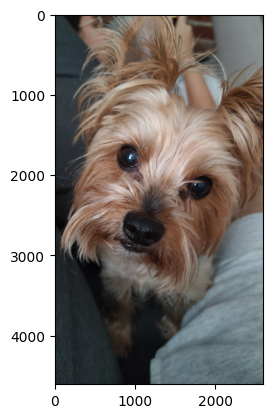

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('Nikus.jpg')
image = np.asarray(image)
plt.imshow(image)

image = Data_modula.transforms(image=image)['image']
class_names = ['pies', 'kot']

In [14]:
print("TORCHVISION")
model_torchvision = CatsVsDogsModel.load_from_checkpoint(checkpoint_callback_torchvision.best_model_path).cpu()
model_torchvision.eval()
outputs = model_torchvision(image.unsqueeze(0))
probs = torch.softmax(outputs, dim=1)
print(probs)
predicted_class = torch.argmax(probs, dim=1).item()
confidence = probs[0, predicted_class].item()

print(f"Obraz przedstawia: {class_names[predicted_class]} (pewność: {confidence:.4f})")
print("="*25)
print("TIM")

model_TIM = CatsVsDogsModel_TIM.load_from_checkpoint(checkpoint_callback_TIM.best_model_path).cpu()
model_TIM.eval()
outputs = model_TIM(image.unsqueeze(0))
probs = torch.softmax(outputs, dim=1)
print(probs)
predicted_class = torch.argmax(probs, dim=1).item()
confidence = probs[0, predicted_class].item()

print(f"Obraz przedstawia: {class_names[predicted_class]} (pewność: {confidence:.4f})")

TORCHVISION
tensor([[9.9999e-01, 5.0688e-06]], grad_fn=<SoftmaxBackward0>)
Obraz przedstawia: pies (pewność: 1.0000)
TIM
tensor([[1.0000e+00, 3.0937e-09]], grad_fn=<SoftmaxBackward0>)
Obraz przedstawia: pies (pewność: 1.0000)


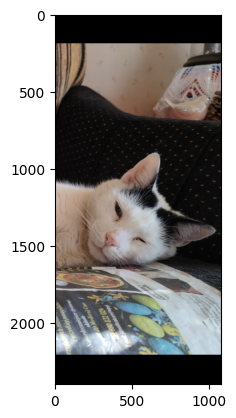

In [15]:
image2 = Image.open('Kot.jpg')
image2 = np.asarray(image2)
plt.imshow(image2)

image2 = Data_modula.transforms(image=image2)['image']

In [16]:
print("TORCHVISION")
model_torchvision = CatsVsDogsModel.load_from_checkpoint(checkpoint_callback_torchvision.best_model_path).cpu()
model_torchvision.eval()
outputs = model_torchvision(image2.unsqueeze(0))
probs = torch.softmax(outputs, dim=1)
print(probs)
predicted_class = torch.argmax(probs, dim=1).item()
confidence = probs[0, predicted_class].item()

print(f"Obraz przedstawia: {class_names[predicted_class]} (pewność: {confidence:.4f})")
print("="*25)
print("TIM")

model_TIM = CatsVsDogsModel_TIM.load_from_checkpoint(checkpoint_callback_TIM.best_model_path).cpu()
model_TIM.eval()
outputs = model_TIM(image2.unsqueeze(0))
probs = torch.softmax(outputs, dim=1)
print(probs)
predicted_class = torch.argmax(probs, dim=1).item()
confidence = probs[0, predicted_class].item()

print(f"Obraz przedstawia: {class_names[predicted_class]} (pewność: {confidence:.4f})")

TORCHVISION
tensor([[0.1203, 0.8797]], grad_fn=<SoftmaxBackward0>)
Obraz przedstawia: kot (pewność: 0.8797)
TIM
tensor([[5.5170e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
Obraz przedstawia: kot (pewność: 1.0000)


TIM

## Narzędzia do śledzenia przebiegu eksperymentów

Istnieje wiele narzędzi umożliwiających śledzenie eksperymentów uczenia maszynowego. Oferują one podgląd przebiegu funkcji kosztu oraz metryk.

Oprócz darmowego [MLFlow](https://mlflow.org/) warto wymienić kilka komercyjnych rozwiązań:
* [Neptune](https://neptune.ai/)
* [Weights and Biases](https://wandb.ai/site)
* [Comet](https://www.comet.com)

`MLFlow` wymaga utworzenia serwera śledzenia eksperymentu, co jest utrudnione w przypadku środowiska Google Colab.

### Zadanie

Załóż darmowe konto https://neptune.ai, utwórz projekt oraz skonfiguruj odpowiednio `Trainer` w bibliotece `Lightning` aby rozpocząć śledzenie eksperymentów: https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.NeptuneLogger.html#lightning.pytorch.loggers.NeptuneLogger.

Obiekt `NeptuneLogger` wymaga podania jedynie dwóch argumentów: nazwy projektu oraz klucza API, który może być również przekazany poprzez zmienną środowiskową `NEPTUNE_API_KEY`.

## Implementacja ResNet-18

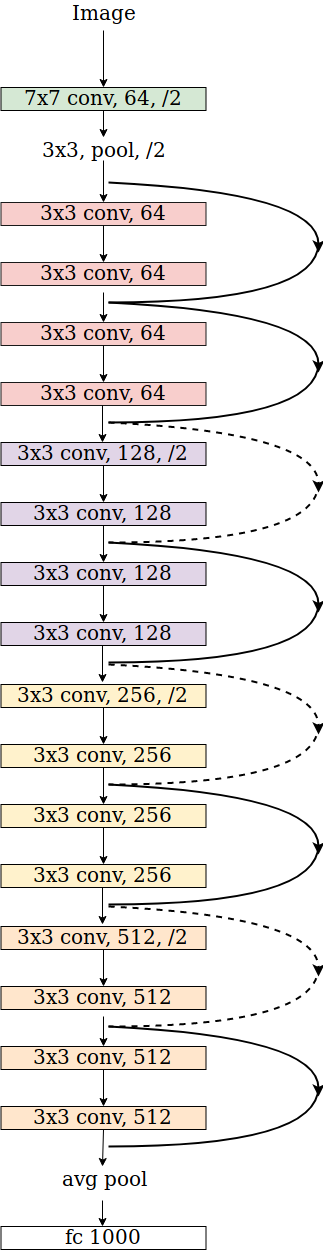